# Import modules

Note: This is the script for word frequency and word cloud after data inferencing is done

In [1]:
import pandas as pd
import numpy as np
import math
import re
import glob
import os
import sys
import random
import pprint as pp
import textwrap
import logging
import spacy
import nltk
import csv

from tqdm.auto import tqdm
tqdm.pandas()

# pandas display options
pd.options.display.max_columns = 30 # default 20
pd.options.display.max_rows = 60 # default 60
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_colwidth = 200 # default 50; None = all
pd.set_option('display.html.use_mathjax', False)

import matplotlib
import matplotlib.pyplot as plt

plot_params = {'figure.figsize': (8, 4),
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}
# adjust matplotlib defaults
matplotlib.rcParams.update(plot_params)

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import dataset

In [6]:
# Importing CSV file for rows containing 13 columns only
output_rows = []
with open("/content/drive/MyDrive/Data/RadicalSpark/InferenceResult.csv", 'r') as f:
    reader = csv.reader(f)
    for row in reader:
      if len(row) == 13:
            output_rows.append(row)

# Now you can convert the list of rows into a DataFrame
df = pd.DataFrame(output_rows[1:], columns=output_rows[0])

In [7]:
len(df)

131386

In [8]:
df.head(2)

,submission_id,comment_id,timestamp,author,body,submission,sub_reddit,upvotes,upvote_ratio,date,body_cleaned,submission_cleaned,prediction
0,1bn6mrm,kwg8o0k,2024-03-25 06:09:14.000,crazyfordimsum,Because WhatsApp requires you to display your mobile number even to strangers. Telegram does not.,Why is WhatsApp not used anymore?,askSingapore,92,0.77,2024-03-25,because whatsapp requires you to display your mobile number even to strangers. telegram does not.,why is whatsapp not used anymore?,0.0
1,1bn6mrm,kwg9buk,2024-03-25 06:17:16.000,Draynor,"When I first started using Telegram, I realised how outdated and feature-lacking WhatsApp was. Requiring a mobile connection to use WhatsApp desktop always felt stupid back then. Other features su...",Why is WhatsApp not used anymore?,askSingapore,92,0.77,2024-03-25,"when i first started using telegram, i realised how outdated and feature-lacking whatsapp was. requiring a mobile connection to use whatsapp desktop always felt stupid back then. other features su...",why is whatsapp not used anymore?,0.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131386 entries, 0 to 131385
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   submission_id       131386 non-null  object
 1   comment_id          131386 non-null  object
 2   timestamp           131386 non-null  object
 3   author              131386 non-null  object
 4   body                131386 non-null  object
 5   submission          131386 non-null  object
 6   sub_reddit          131386 non-null  object
 7   upvotes             131386 non-null  object
 8   upvote_ratio        131386 non-null  object
 9   date                131386 non-null  object
 10  body_cleaned        131386 non-null  object
 11  submission_cleaned  131386 non-null  object
 12  prediction          131386 non-null  object
dtypes: object(13)
memory usage: 13.0+ MB


In [10]:
df['prediction'].describe()

count     131386
unique         2
top          0.0
freq      130349
Name: prediction, dtype: object

In [11]:
df['prediction'].unique()

array(['0.0', '1.0'], dtype=object)

In [12]:
radical_df = df[df['prediction'] == '1.0']
len(radical_df)

1037

In [13]:
radical_df.head()

,submission_id,comment_id,timestamp,author,body,submission,sub_reddit,upvotes,upvote_ratio,date,body_cleaned,submission_cleaned,prediction
119,1bndk7i,kwho1fk,2024-03-25 14:30:47.000,Ninjamonsterz,Let's be honest - 99.99999999% of those who went private uni chose the path before they cannot get into local uni due to grades. No.other.reasons.,Does anyone in Singapore actually go to private uni? What are your reasons?,askSingapore,0,0.35,2024-03-25,let's be honest - 99.99999999% of those who went private uni chose the path before they cannot get into local uni due to grades. no.other.reasons.,does anyone in singapore actually go to private uni? what are your reasons?,1.0
290,1bpa1s7,kwvn7ce,2024-03-27 23:42:30.000,tuxdj0079,"If a party is willing to offend, skin colour is one of the many methods.",What do you guys do when your parents go on a racist rant?,askSingapore,72,0.89,2024-03-27,"if a party is willing to offend, skin colour is one of the many methods.",what do you guys do when your parents go on a racist rant?,1.0
312,1bn1edr,kwgkjzc,2024-03-25 08:41:03.000,kyrandia71,"No need. Most non-Chinese local Singaporean Malays and Indians can speak English. Non-local Chinese (Malaysians, Chinese nationals can speak Mandarin).",Languages in SG,askSingapore,0,0.24,2024-03-25,"no need. most non-chinese local singaporean malays and indians can speak english. non-local chinese (malaysians, chinese nationals can speak mandarin).",languages in sg,1.0
325,1boxuoy,kwwiuwe,2024-03-28 03:08:37.000,anonnautilus,I am 60yrs old. Very sedentary. 158 cm n 54kg. Also overweight. Also has a son who is on my case to exercise. Recently i walked a lot n ended up with painful swollen legs n feet. Suggest u dont te...,Mom (58F) does not want to listen,askSingapore,228,0.96,2024-03-28,i am 60yrs old. very sedentary. 158 cm n 54kg. also overweight. also has a son who is on my case to exercise. recently i walked a lot n ended up with painful swollen legs n feet. suggest u dont te...,mom (58f) does not want to listen,1.0
326,1boxuoy,kwwnz0g,2024-03-28 03:48:40.000,IndependenceVast3824,"Try starting with low impact workout or something like yoga? Maybe start with 3 times a week and then gradually increase it. And fat is lost in the kitchen, so really try to make her eat healthy a...",Mom (58F) does not want to listen,askSingapore,228,0.96,2024-03-28,"try starting with low impact workout or something like yoga? maybe start with 3 times a week and then gradually increase it. and fat is lost in the kitchen, so really try to make her eat healthy a...",mom (58f) does not want to listen,1.0


# Tokenization with regex and stop words removal

In [ ]:
import regex as re

def tokenize(text):
  return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [ ]:
import nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_stop(tokens):
  return [t for t in tokens if t.lower() not in stopwords]

In [ ]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [ ]:
df['tokens'] = df['body_cleaned'].apply(prepare, pipeline=pipeline)

In [ ]:
print(df['tokens'])

0                                                                                                                                        [whatsapp, requires, display, mobile, number, even, strangers, telegram]
1         [first, started, using, telegram, realised, outdated, feature-lacking, whatsapp, requiring, mobile, connection, use, whatsapp, desktop, always, felt, stupid, back, features, customisation, sticker...
2                                                                                                                                                                    [whatsapp, work, telegram, everything, else]
3                                          [telegram, way, better, function, compared, wa, number, shielded, tele, tele, cloud, hosting, really, convenient, spend, hours, trying, backup, wa, port, new, device]
4         [easy, migrate, connect, multiple, phones, need, share, phone, delete, something, announce, deleted, something, lol, chat, folders, telegram, alot, pr

# Word frequency distribution

In [ ]:
all_tokens = [token for row in df['tokens'] for token in row]
radical_all_tokens = [token for row in df['tokens'][df['prediction']=='1.0'] for token in row]

In [ ]:
from collections import Counter

# count the frequency of each token
token_counts = Counter(all_tokens)
radical_token_counts = Counter(radical_all_tokens)

# print the word frequency distribution
print("Token count for all tokens")
print(token_counts)
print(" ")
print("Token count for radical posts tokens")
print(radical_token_counts)

Token count for all tokens
Counter({'like': 11636, 'get': 8126, 'people': 7333, 'one': 7302, 'u': 7154, 'go': 6248, 'think': 6245, 'time': 6182, 'also': 5943, 'even': 5725, 'good': 5642, 'would': 5211, 'know': 4983, 'work': 4981, 'need': 4910, 'still': 4848, 'really': 4611, 'got': 4597, 'much': 4214, 'lol': 4200, 'want': 4053, 'singapore': 3976, 'see': 3969, 'well': 3629, 'make': 3519, 'take': 3512, 'say': 3111, 'better': 3091, 'years': 3051, 'many': 2996, 'back': 2909, 'way': 2860, 'life': 2840, 'day': 2839, 'yes': 2776, 'first': 2738, 'sure': 2737, 'job': 2687, 'right': 2674, 'sg': 2667, 'money': 2577, 'maybe': 2488, 'going': 2487, 'try': 2478, 'never': 2470, 'thanks': 2467, 'use': 2413, 'always': 2321, 'already': 2306, 'us': 2267, 'find': 2263, 'school': 2220, 'year': 2217, 'feel': 2213, 'ask': 2192, 'best': 2170, 'since': 2168, 'long': 2095, 'pay': 2071, 'could': 2025, 'give': 2011, 'actually': 2009, 'someone': 1963, 'friends': 1957, 'lot': 1955, 'something': 1950, 'thank': 1949, '

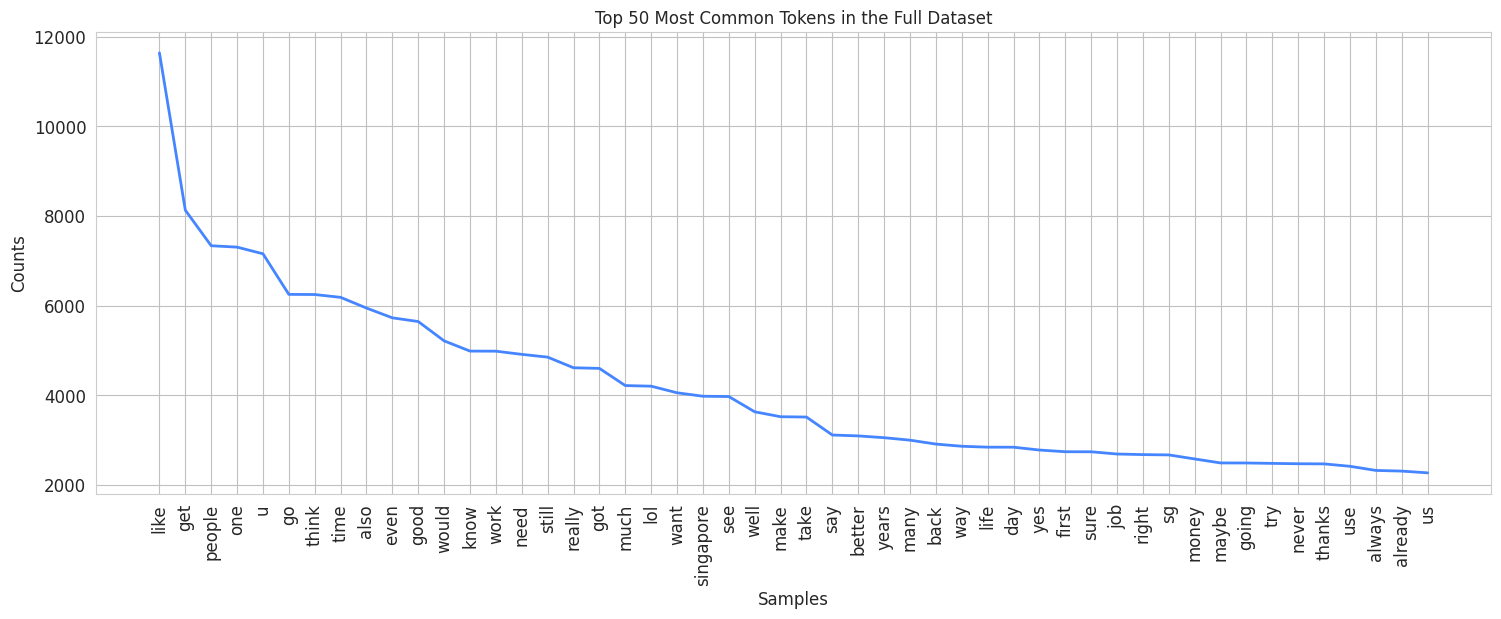

In [ ]:
number_of_tokens = 50

plt.figure(figsize=(18,6))
plt.title('Top {} Most Common Tokens in the Full Dataset'.format(number_of_tokens))

fd = nltk.FreqDist(token_counts)
# print(fd.most_common(50))

fd.plot(number_of_tokens, color=(0.27, 0.52, 1.0))

plt.show()

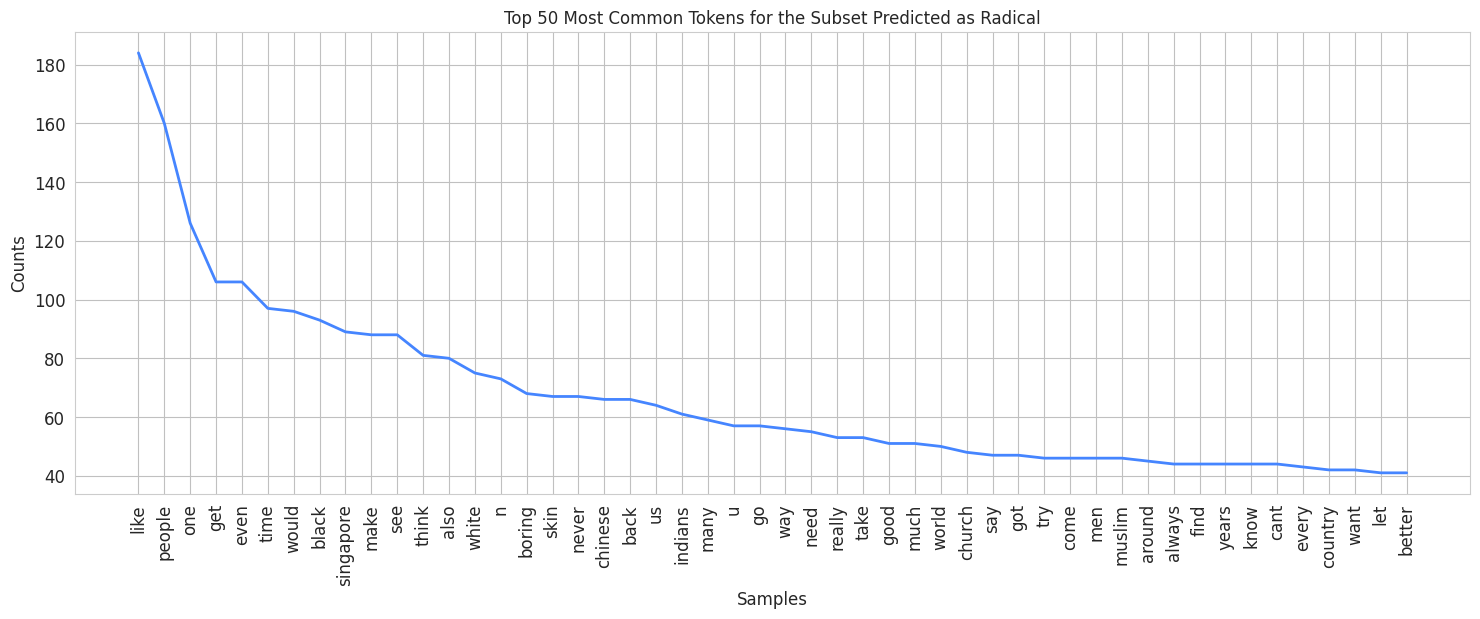

In [ ]:
number_of_tokens = 50

plt.figure(figsize=(18,6))
plt.title('Top {} Most Common Tokens for the Subset Predicted as Radical'.format(number_of_tokens))

fd = nltk.FreqDist(radical_token_counts)
# print(fd.most_common(50))

fd.plot(number_of_tokens, color=(0.27, 0.52, 1.0))

plt.show()

# Word Cloud

In [ ]:
pip install wordcloud

In [ ]:
from wordcloud import WordCloud

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400,
                   background_color= "white", colormap="Blues",
                   max_font_size=150, max_words=max_words)

    # convert DataFrame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [ ]:
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens) #The update() method inserts the specified items to the dictionary.The specified items can be a dictionary, or an iterable object with key value pairs.

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

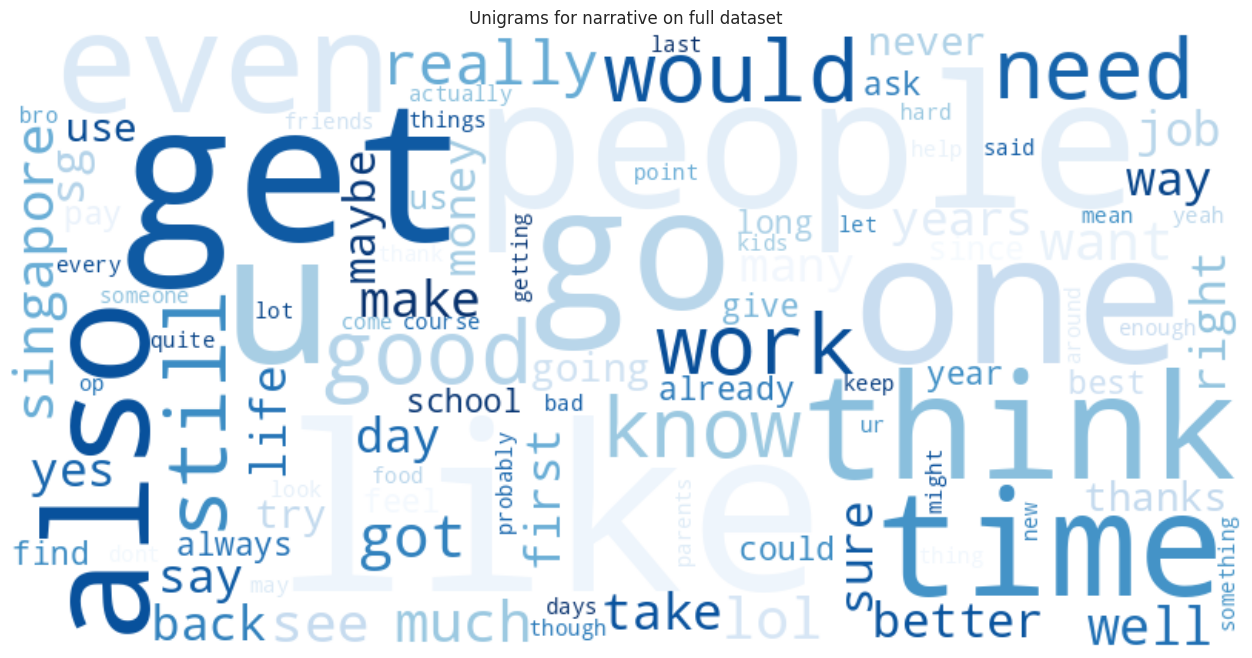

In [ ]:
# Here we try to find out the word cloud of the top 100 words for all the rows in our dataset

freq_all_df = count_words(df)
plt.figure(figsize=(16,8))
wordcloud(freq_all_df['freq'], title='Unigrams for narrative on full dataset', max_words=100)

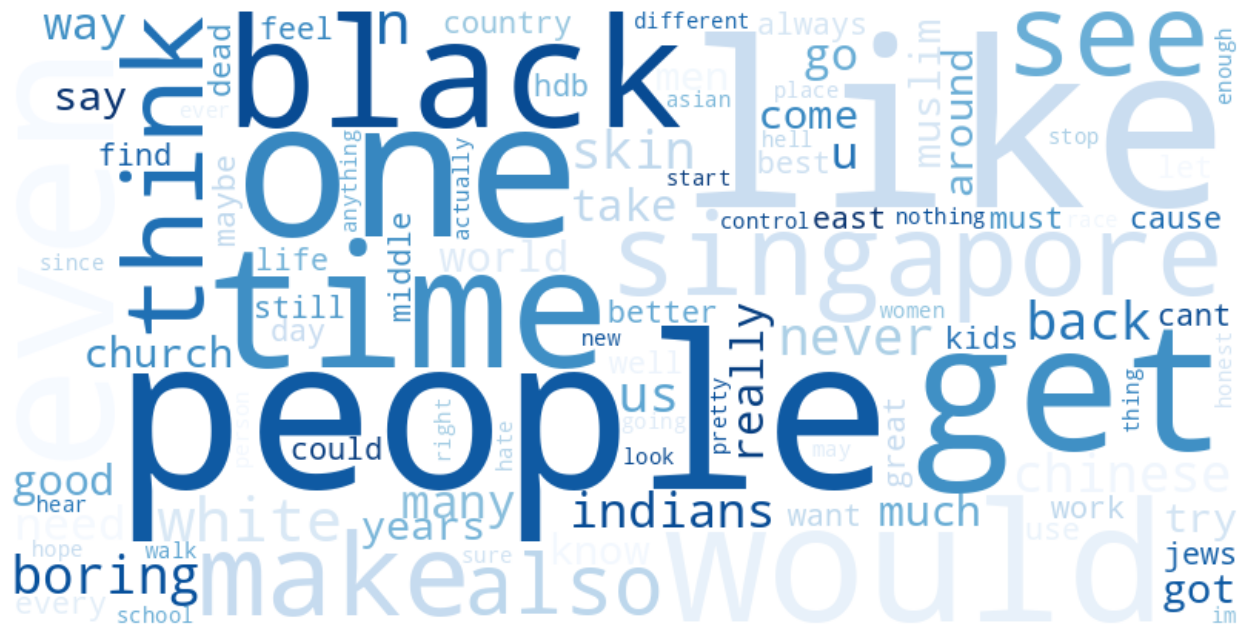

In [ ]:
# Here we try to find out the word cloud of the top 100 words where it was classified as radical

radical_label_df = count_words(df[df['prediction']== '1.0'])
plt.figure(figsize=(16,8))
wordcloud(radical_label_df['freq'], max_words=100)

# tf-idf

In [ ]:
def compute_idf(df, column='tokens', preprocess=None, min_df=2):

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(set(tokens))

    # count tokens
    counter = Counter()
    df[column].map(update)

    # create DataFrame and compute idf
    idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
    idf_df = idf_df.query('df >= @min_df')
    idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1
    idf_df.index.name = 'token'
    return idf_df

In [ ]:
idf_df = compute_idf(df)

<ipython-input-26-f8cb23ecfb8c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


In [ ]:
freq_df = count_words(df)

In [ ]:
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

In [ ]:
freq_df.head(5)

,freq,tfidf
token,,
like,11636,30758.34
get,8126,24221.35
people,7333,22893.61
one,7302,22508.20
u,7154,23802.62


In [ ]:
freq_df.tail(5)

,freq,tfidf
token,,
alco,2,22.39
insinuation,2,22.39
flank,2,22.39
pulse,2,22.39
monetized,2,22.39


# N-gram (bigram and trigram)

In [ ]:
def ngrams(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

# Here we test the function by using one of the sample narrative printed earlier
text = "Over the course of several years, two convicts form a friendship, seeking consolation and, eventually, redemption through basic compassion."
tokens = tokenize(text)
print("|".join(ngrams(tokens, 2)))

Over the|the course|course of|of several|several years|years two|two convicts|convicts form|form a|a friendship|friendship seeking|seeking consolation|consolation and|and eventually|eventually redemption|redemption through|through basic|basic compassion


In [ ]:
# We can see that stopwords are still inside the bigram above, so we only return the bigram when there is no stopword
def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
            if len([t for t in ngram if t in stopwords])==0]

print("Bigrams:", "|".join(ngrams(tokens, 2, stopwords=stopwords)))
print("Trigrams:", "|".join(ngrams(tokens, 3, stopwords=stopwords)))

Bigrams: several years|years two|two convicts|convicts form|friendship seeking|seeking consolation|eventually redemption|basic compassion
Trigrams: several years two|years two convicts|two convicts form|friendship seeking consolation


In [ ]:
df['bigrams'] = df['body_cleaned'].apply(prepare, pipeline=[str.lower, tokenize]) \
                          .apply(ngrams, n=2, stopwords=stopwords)

count_words(df, 'bigrams').head(5)

,freq
token,
sounds like,490
feel like,471
years ago,388
seems like,359
good luck,325


<ipython-input-26-f8cb23ecfb8c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


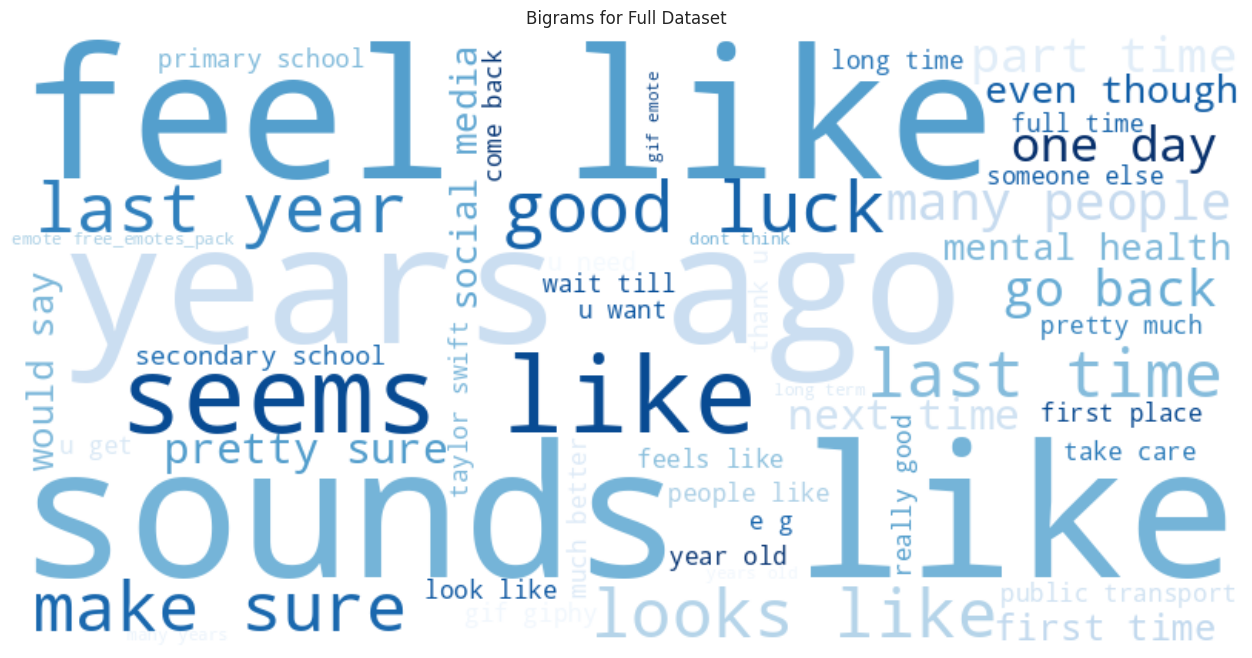

In [ ]:
# Creating the word cloud with bigram for full dataset
# reset the index of the idf_df DataFrame
idf_df = idf_df.reset_index(drop=True)

# concatenate existing IDF DataFrame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df, 'bigrams')

freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

plt.figure(figsize=(16,8))
wordcloud(freq_df['tfidf'], title='Bigrams for Full Dataset', max_words=50)

<ipython-input-26-f8cb23ecfb8c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


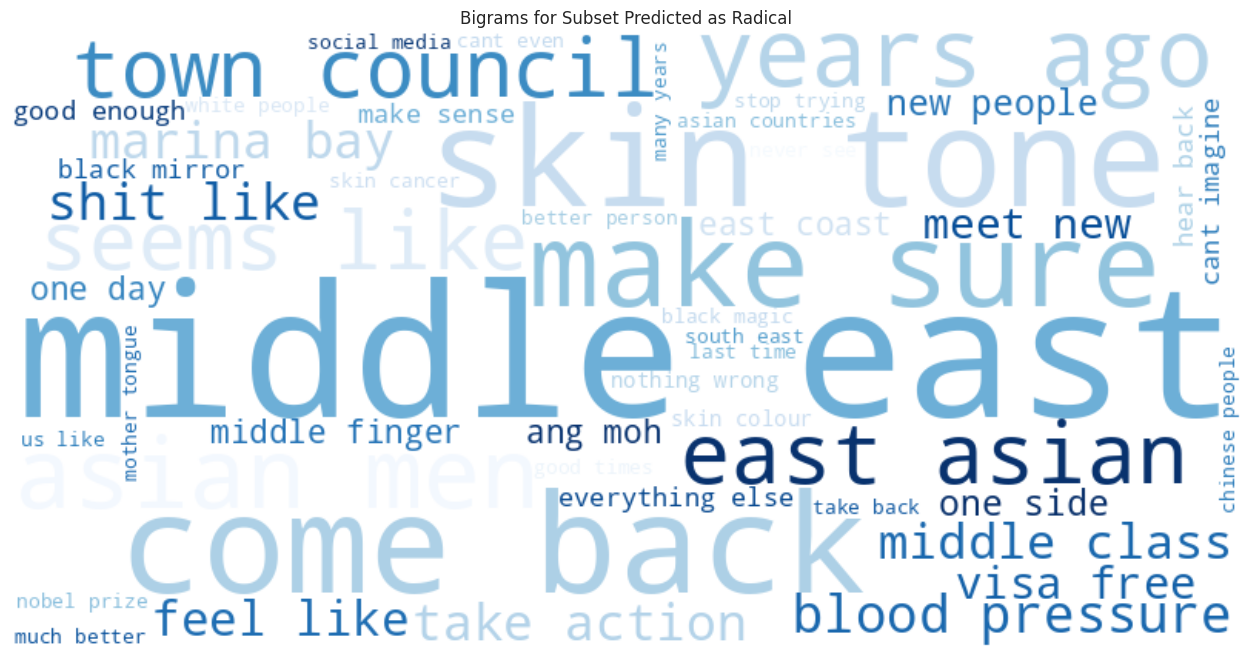

In [ ]:
# Creating the word cloud with bigram for radical posts
# reset the index of the idf_df DataFrame
idf_df = idf_df.reset_index(drop=True)

# concatenate existing IDF DataFrame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['prediction'] == "1.0"], 'bigrams')

freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

plt.figure(figsize=(16,8))
wordcloud(freq_df['tfidf'], title='Bigrams for Subset Predicted as Radical', max_words=50)

In [ ]:
df['trigrams'] = df['body_cleaned'].apply(prepare, pipeline=[str.lower, tokenize]) \
                          .apply(ngrams, n=3, stopwords=stopwords)

count_words(df, 'trigrams').head(5)

,freq
token,
gif emote free_emotes_pack,138
work life balance,81
sinkie pwn sinkie,47
day work week,45
many years ago,37


<ipython-input-26-f8cb23ecfb8c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


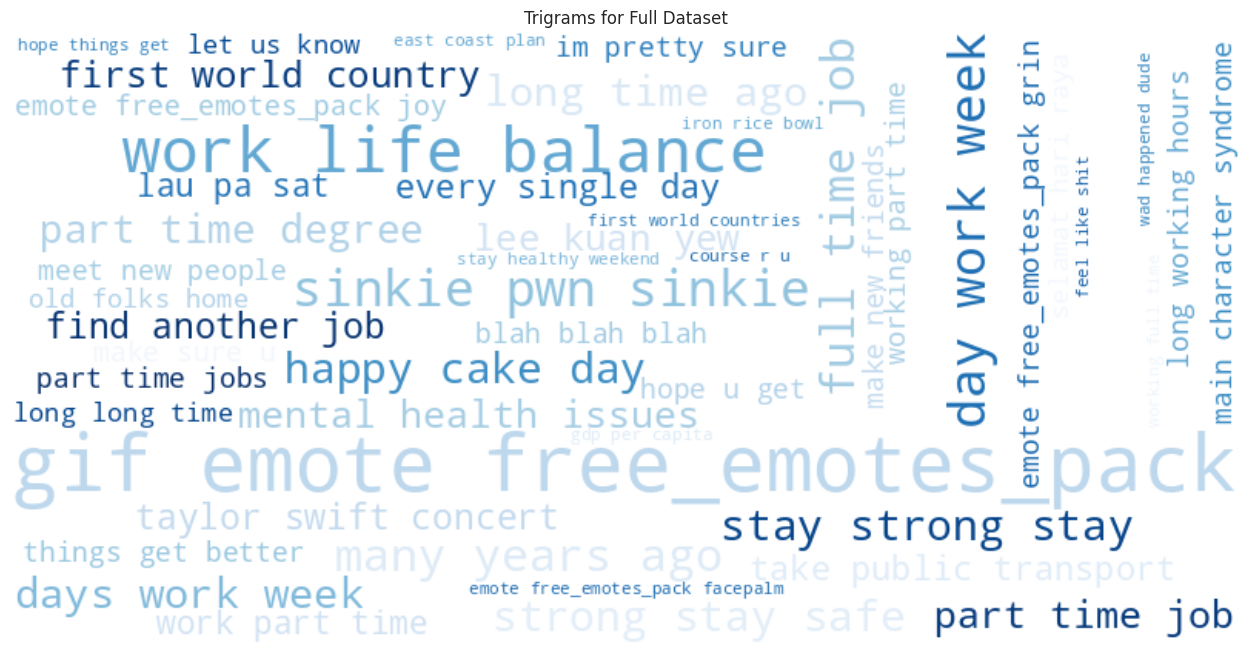

In [ ]:
# Creating the word cloud with trigram for full dataset
# reset the index of the idf_df DataFrame
idf_df = idf_df.reset_index(drop=True)

# concatenate existing IDF DataFrame with trigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'trigrams', min_df=10)])

freq_df = count_words(df, 'trigrams')

freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

plt.figure(figsize=(16,8))
wordcloud(freq_df['tfidf'], title='Trigrams for Full Dataset', max_words=50)

<ipython-input-26-f8cb23ecfb8c>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idf_df['idf'] = np.log(len(df)/idf_df['df'])+0.1


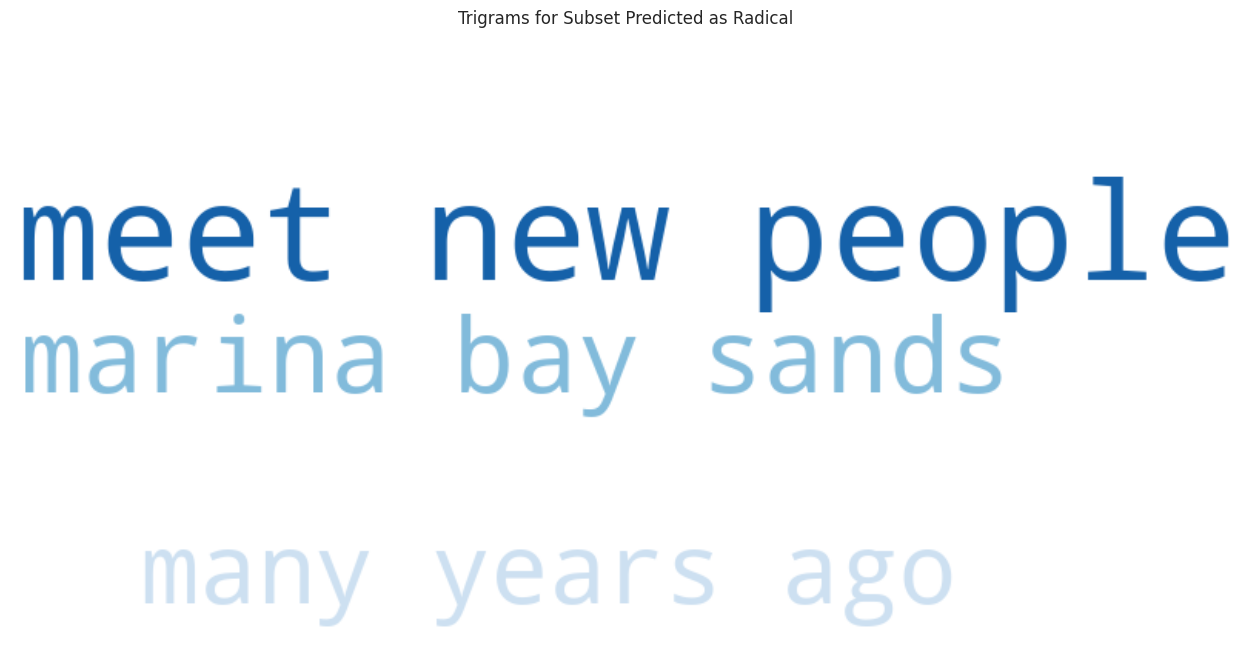

In [ ]:
# Creating the word cloud with trigram for radical post
# reset the index of the idf_df DataFrame
idf_df = idf_df.reset_index(drop=True)

# concatenate existing IDF DataFrame with trigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'trigrams', min_df=10)])

freq_df = count_words(df[df['prediction'] == "1.0"], 'trigrams')

freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

plt.figure(figsize=(16,8))
wordcloud(freq_df['tfidf'], title='Trigrams for Subset Predicted as Radical', max_words=50)

-End-